In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

C:\Users\wjw_4\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def load_and_merge_data(feature_file, age_file):
    """
    Load features and age CSVs, merge on Patient_ID, and return a DataFrame.
    """
    try:
        # Load feature CSV
        features_df = pd.read_csv(feature_file)
        if 'ID' not in features_df.columns:
            raise ValueError("ID column not found in extracted_features.csv")
        
        # Load age CSV
        age_df = pd.read_csv(age_file)
        if 'ID' not in age_df.columns or 'Age' not in age_df.columns:
            raise ValueError("ID or Age column not found in oasis_cross-sectional-5708aa0a98d82080.csv")
        
        # Merge on Patient_ID
        df = pd.merge(features_df, age_df[['ID', 'Age']], on='ID', how='inner')
        
        if df.empty:
            raise ValueError("No matching Patient_IDs found between feature and age CSVs")
        
        print(f"Merged data for {len(df)} patients.")
        return df
    except Exception as e:
        print(f"Error loading or merging data: {e}")
        return None

In [3]:
def perform_svr_regression(df):
    """
    Perform SVR and calculate brain age gap.
    Returns model, predictions, and brain age gap.
    """
    # Drop non-feature columns
    X = df.drop(columns=['ID', 'Age'])
    y = df['Age']
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Define SVR model and hyperparameter grid
    svr = SVR(kernel='rbf')
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.1, 0.5, 1, 2]
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    model = grid_search.best_estimator_
    print(f"Best SVR parameters: {grid_search.best_params_}")
    
    # Predict brain age
    y_pred = model.predict(X_test)
    
    # Calculate brain age gap
    brain_age_gap = y_pred - y_test
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.2f} years")
    print(f"R² Score: {r2:.2f}")
    
    return model, X_test, y_test, y_pred, brain_age_gap, df.loc[y_test.index, 'ID']

In [4]:
def visualize_results(y_test, y_pred, brain_age_gap):
    """
    Visualize predicted vs actual age and brain age gap distribution.
    """
    plt.figure(figsize=(12, 5))
    
    # Predicted vs actual age
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Predicted vs Actual Brain Age (SVR)')
    
    # Brain age gap distribution
    plt.subplot(1, 2, 2)
    plt.hist(brain_age_gap, bins=20, edgecolor='black')
    plt.xlabel('Brain Age Gap (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.title('Brain Age Gap Distribution (SVR)')
    
    plt.tight_layout()
    plt.show()

/Users/wjw_4/Documents/Helsa 
Loading and merging data...
Merged data for 31 patients.
Data preview:
              ID  image_size_x  image_size_y  image_size_z  pixel_size_x  \
0  OAS1_0001_MR1           176           208           176           1.0   
1  OAS1_0002_MR1           176           208           176           1.0   
2  OAS1_0003_MR1           176           208           176           1.0   
3  OAS1_0004_MR1           176           208           176           1.0   
4  OAS1_0005_MR1           176           208           176           1.0   

   pixel_size_y  pixel_size_z  tissue_0_mean  tissue_0_stddev  tissue_1_mean  \
0           1.0           1.0        384.521          162.773        851.126   
1           1.0           1.0        423.352          155.224        827.705   
2           1.0           1.0        387.006          158.527        896.728   
3           1.0           1.0        403.657          149.747        801.315   
4           1.0           1.0        453.8

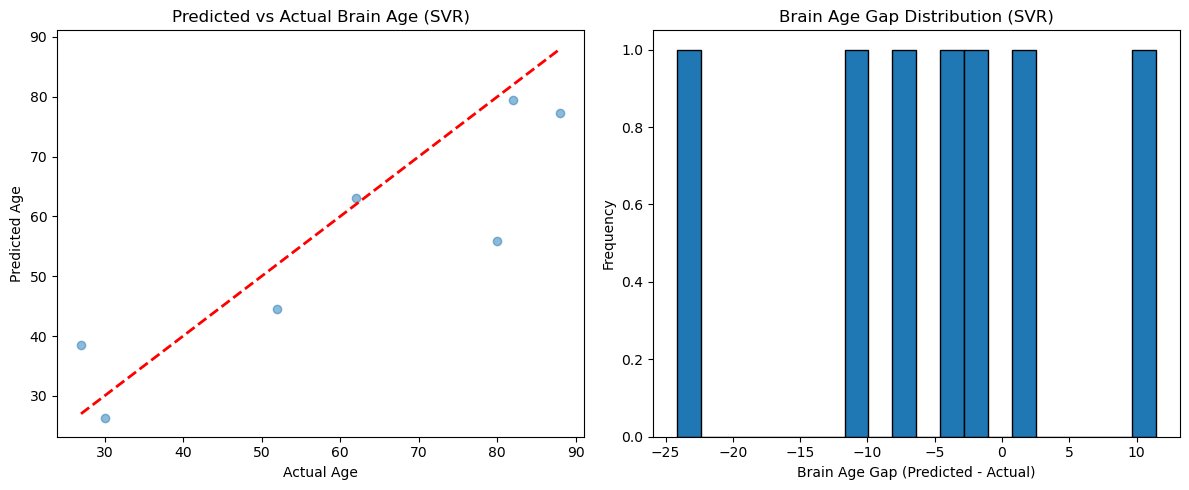


Results saved to RE_svr_results.csv


In [5]:
if __name__ == "__main__":
    # Specify parent directory
    parent_dir = input("/Users/wjw_4/Documents/Helsa ")
    
    # File paths
    feature_file = os.path.join(parent_dir, 'extracted_features.csv')
    age_file = os.path.join(parent_dir, 'oasis_cross-sectional-5708aa0a98d82080.csv')
    
    # Load and merge data
    print("Loading and merging data...")
    df = load_and_merge_data(feature_file, age_file)
    
    if df is None or df.empty:
        print("Failed to load data. Please check file paths and formats.")
    else:
        print("Data preview:")
        print(df.head())
        
        # Perform SVR regression
        print("\nTraining SVR model...")
        model, X_test, y_test, y_pred, brain_age_gap, test_patient_ids = perform_svr_regression(df)
        
        # Visualize results
        print("\nVisualizing results...")
        visualize_results(y_test, y_pred, brain_age_gap)
        
        # Save results
        results = pd.DataFrame({
            'ID': test_patient_ids,
            'Actual_Age': y_test,
            'Predicted_Age': y_pred,
            'Brain_Age_Gap': brain_age_gap
        })
        results.to_csv(os.path.join(parent_dir, 'RE_svr_results.csv'), index=False)
        print(f"\nResults saved to {os.path.join(parent_dir, 'RE_svr_results.csv')}")